In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler

2023-05-14 02:32:07.186466: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-14 02:32:07.212088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 02:32:07.656799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_parquet("data/dataset_depth8_Sam_Raph_Sothatsit7_Kaggle.parquet").sample(frac=0.01)
df = df.drop(["rank", "utility", "game"], axis="columns")
df["light_turn"] = df["light_turn"] == "true"
df["x"] = df["x"].replace({"A": 0, "B": 1, "C": 2})
cols_to_replace = [c for c in df.columns if c.startswith("A") or c.startswith("B") or c.startswith("C")]

df[cols_to_replace] = df[cols_to_replace].replace({"E": 0, "L": -1, "D": 1})

scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(df)
print(scaled)

[[0.66666667 1.         0.14285714 ... 1.         0.5        0.        ]
 [0.66666667 0.5        0.42857143 ... 1.         0.         0.        ]
 [0.         0.5        1.         ... 1.         1.         0.        ]
 ...
 [0.         1.         0.85714286 ... 0.         0.5        0.        ]
 [0.66666667 0.5        0.14285714 ... 1.         0.         1.        ]
 [0.66666667 0.5        0.42857143 ... 1.         0.5        0.        ]]


In [3]:
scaled.shape

(384323, 28)

In [7]:
latent_dim = 3

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Dense(latent_dim, activation='sigmoid'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(28, activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [8]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [10]:
autoencoder.fit(scaled, scaled,
                epochs=10,
                #batch_size=5000,
                shuffle=True,
                validation_data=(scaled, scaled))

Epoch 1/10
12011/12011 [==============================] - 61s 5ms/step - loss: 0.1111 - val_loss: 0.1107
Epoch 2/10
 5171/12011 [===========>..................] - ETA: 25s - loss: 0.1106

KeyboardInterrupt: 

In [67]:
encoded_imgs = autoencoder.encoder(scaled).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [69]:
encoded_imgs.shape

(384323, 5)

In [70]:
encoded_imgs

array([[0.6734739 , 0.45522827, 0.21411319, 0.07543892, 0.46074665],
       [0.94373274, 0.5489187 , 0.8528647 , 0.04292059, 0.23142534],
       [0.12105013, 0.7600485 , 0.24988826, 0.33209142, 0.97750103],
       ...,
       [0.9716242 , 0.7791416 , 0.71233225, 0.17078876, 0.20171623],
       [0.7847162 , 0.12163758, 0.42539123, 0.71007276, 0.9114587 ],
       [0.06398454, 0.962587  , 0.13663325, 0.4720058 , 0.2553022 ]],
      dtype=float32)

In [73]:
import umap
reducer = umap.UMAP(verbose=True, n_neighbors=100)
embedding = reducer.fit_transform(encoded_imgs)

UMAP(n_neighbors=100, verbose=True)
Fri May 12 00:00:48 2023 Construct fuzzy simplicial set
Fri May 12 00:00:48 2023 Finding Nearest Neighbors
Fri May 12 00:00:48 2023 Building RP forest with 36 trees
Fri May 12 00:00:48 2023 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	Stopping threshold met -- exiting after 2 iterations
Fri May 12 00:03:13 2023 Finished Nearest Neighbor Search
Fri May 12 00:03:21 2023 Construct embedding


KeyboardInterrupt: 

Text(0.5, 1.0, 'UMAP projection of the UR dataset')

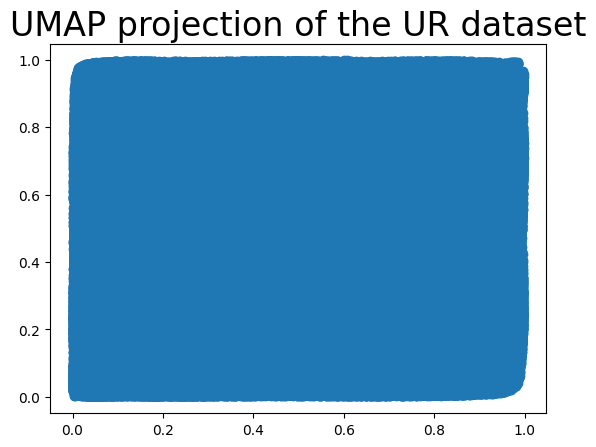

In [61]:
plt.scatter(
    encoded_imgs[:, 0],
    encoded_imgs[:, 1],
    #c=MinMaxScaler().fit_transform(df["utility"]),
    #cmap='Spectral',
)
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the UR dataset', fontsize=24)

Text(0.5, 1.0, 'UMAP projection of the MNIST Fashion dataset')

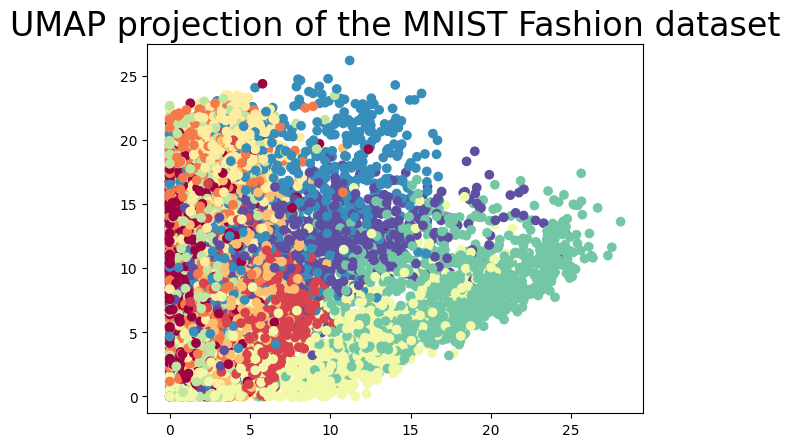

In [18]:
plt.scatter(
    encoded_imgs[:, 1],
    encoded_imgs[:, 2],
    c=y_test,
    cmap='Spectral',
)
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the MNIST Fashion dataset', fontsize=24)

Text(0.5, 1.0, 'UMAP projection of the MNIST Fashion dataset')

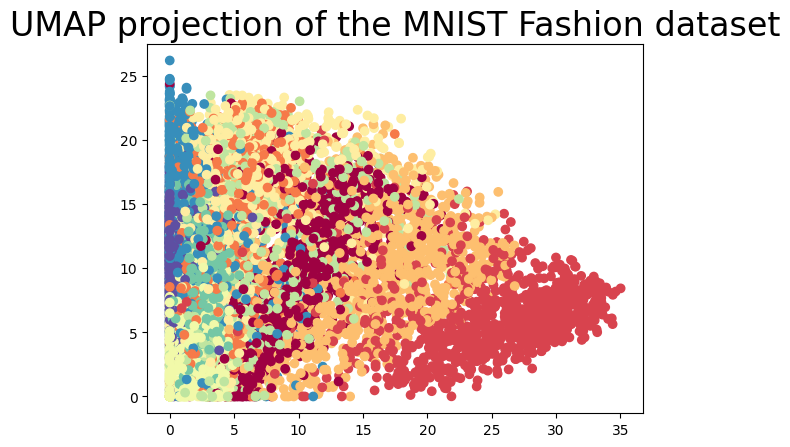

In [19]:
plt.scatter(
    encoded_imgs[:, 0],
    encoded_imgs[:, 2],
    c=y_test,
    cmap='Spectral',
)
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the MNIST Fashion dataset', fontsize=24)

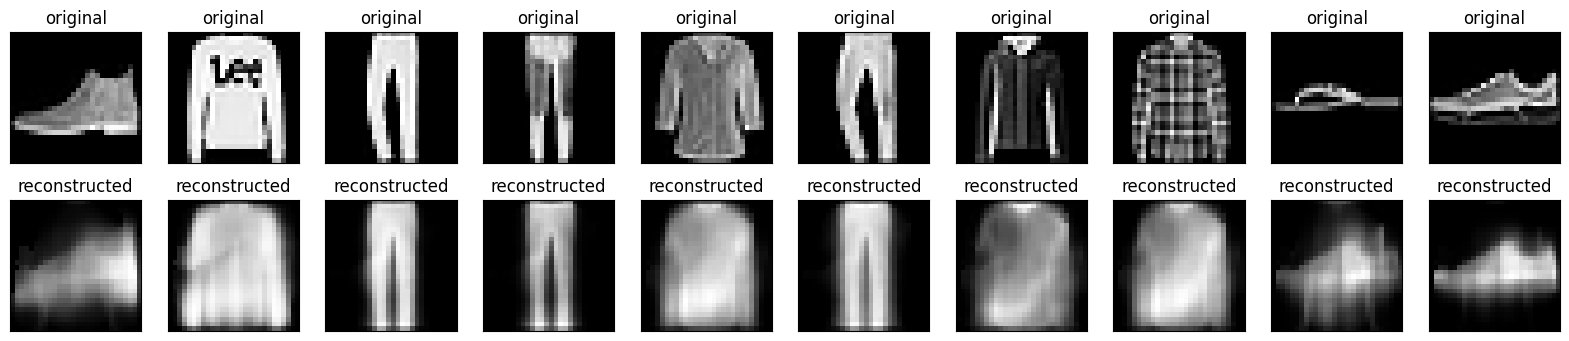

In [20]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

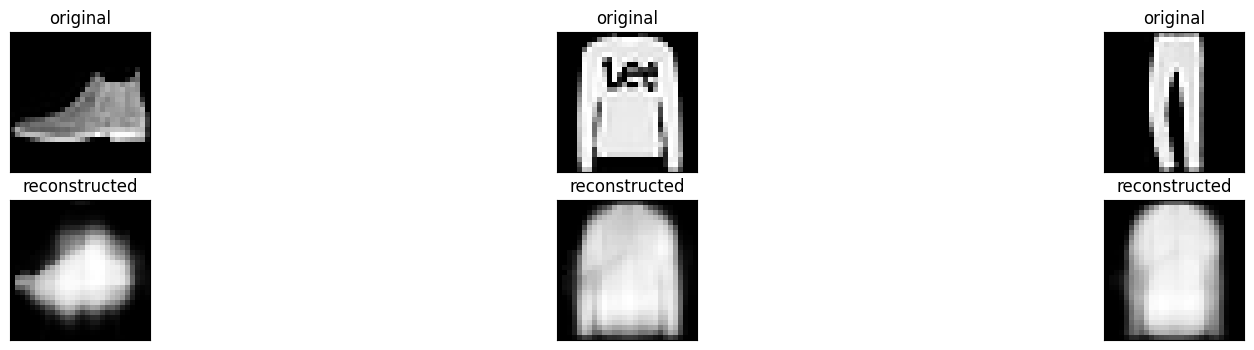

In [36]:
g = np.array([
  [8, 20, 20],
  [5, 3, 20],
  [10, 3, 20],
])
tesss = autoencoder.decoder(g).numpy()
n = g.shape[0]
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(tesss[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()